This notebook is to calculate the 3D zero-loss and plasmon reconstruction from EELS SI

In [1]:
#use this for interactive pop up images
#%matplotlib qt5

In [2]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
import pandas as pd
import time
import gc
import os
from os.path import exists
from scipy.spatial.transform import Rotation
import scipy as sc
from numpy.linalg import norm
import h5py
import dask.array as da
from skimage.transform import resize
import mrcfile
import pyclesperanto_prototype as cle
import scipy.ndimage as ndimage
from ipywidgets import IntProgress
from IPython.display import display
cle.select_device("GTX")

<NVIDIA GeForce GTX 1050 Ti on Platform: NVIDIA CUDA (1 refs)>

In [3]:
#load the EELS SI
#change path here
# image names are expected to be 'SI_' + str(index)

dmpath = 'D:/data/August2022/TiNi/tomo/Tomo_44/SI/'
test = 'SI_' + str(0)

s_ll = hs.load(dmpath + test + '.dm4')

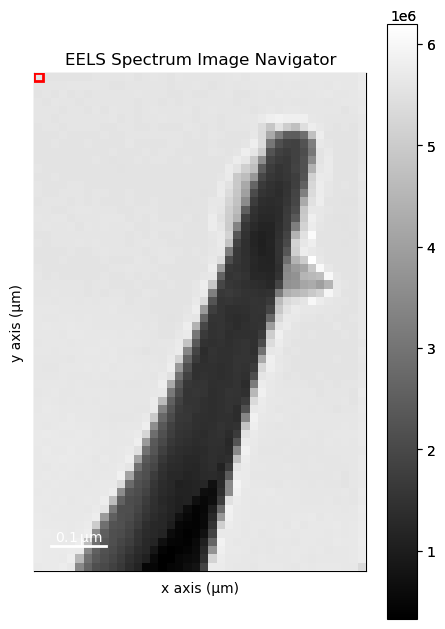

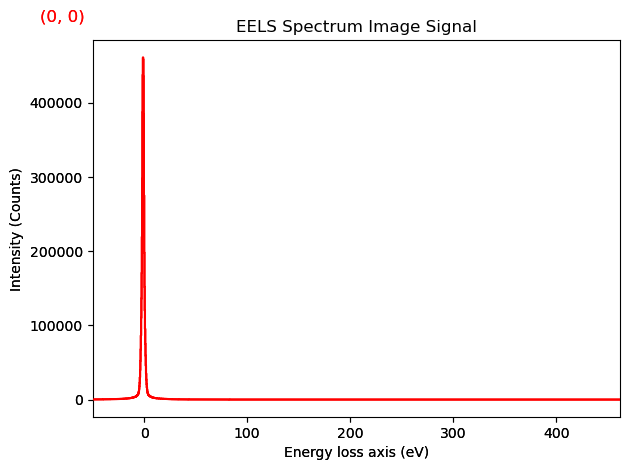

In [4]:
s_ll.plot()

In [5]:
s_ll.align_zero_loss_peak(subpixel=True, signal_range=[-5.0,5.0])

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-0.502
std:	0.204

min:	-1.25
Q1:	-0.75
median:	-0.5
Q3:	-0.25
max:	0
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s


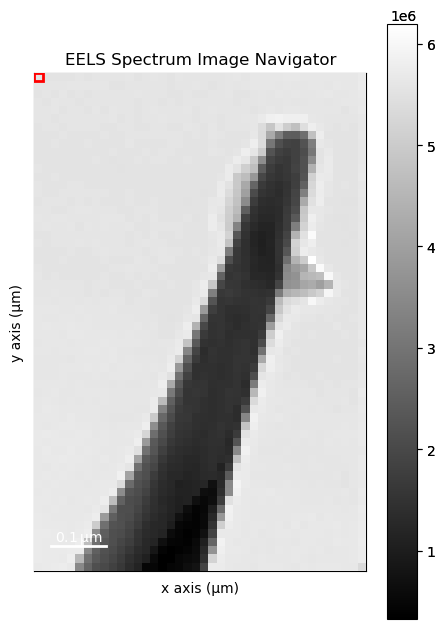

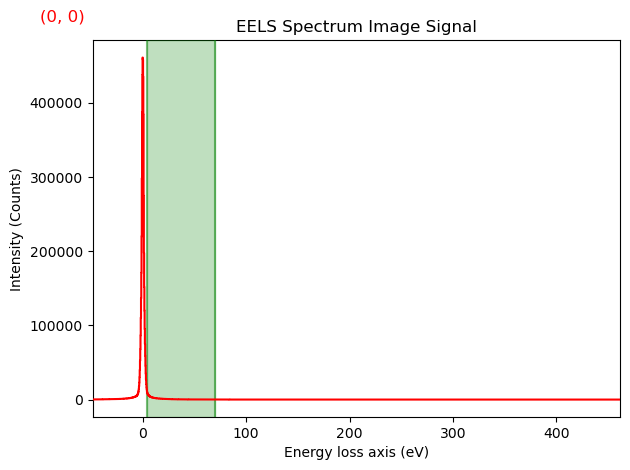

In [6]:
roi_ZL = hs.roi.SpanROI(left=-7, right=3) # zero loss
roi_PL = hs.roi.SpanROI(left=4, right=70) # plasmon
s_ll.plot()
roi_PL.add_widget(s_ll, axes=["Energy loss"])

In [7]:
s_ti = s_ll.isig[roi_PL].integrate1D(axis="Energy loss")

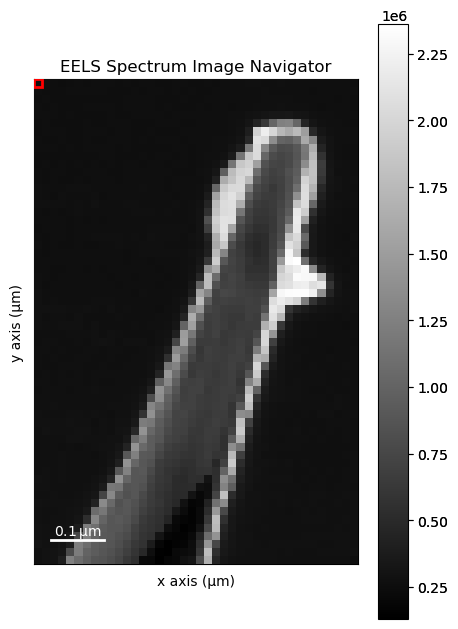

In [8]:
s_ti.plot()

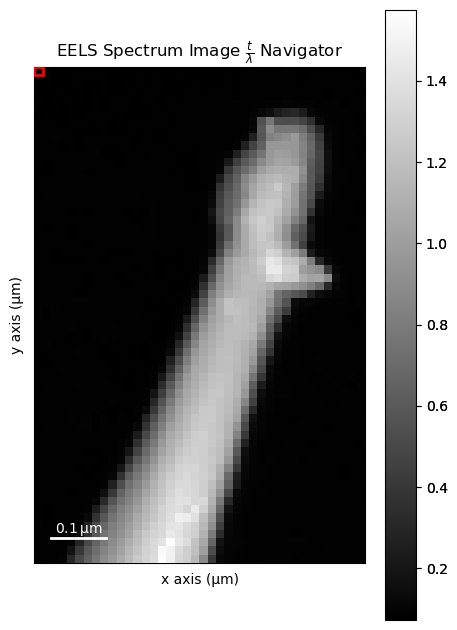

In [10]:
#some variables

s_ll.add_elements(('Ni','Ti'))
s_ll.metadata.Acquisition_instrument.TEM.Detector.EELS.collection_angle = 7.24638
s_ll.metadata.Acquisition_instrument.TEM.Detector.EELS.convergence_angle = 0.5
s_ll.metadata.Acquisition_instrument.TEM.Detector.EELS.beam_energy = 300.0
s_ll.metadata.Sample.density = 6.60 # wont take away the warning on estimate_thickness function ?!?
s_ll.metadata
s_thickness = s_ll.estimate_thickness(threshold=3.0)
s_thickness.plot()

In [11]:
# make tiltseries for zero-loss and plasmon

#change number of tilts here
Ntilts = 70

test = 'SI_' + str(0)
s_ll = hs.load(dmpath + test + '.dm4')
    
s_ZL_stack = np.zeros((Ntilts, s_ll.data.shape[0], s_ll.data.shape[1]))
s_PL_stack = np.zeros((Ntilts, s_ll.data.shape[0], s_ll.data.shape[1]))

for i in range(Ntilts):
    print('tilt', i)
    test = 'SI_' + str(i)
    s_ll = hs.load(dmpath + test + '.dm4')
    
    s_ll.align_zero_loss_peak(subpixel=True, signal_range=[-5.0,5.0], print_stats=False)
    
    roi_ZL = hs.roi.SpanROI(left=-7, right=3) # zero loss
    roi_PL = hs.roi.SpanROI(left=4, right=70) # plasmon
    
    s_ZL = s_ll.isig[roi_ZL].integrate1D(axis="Energy loss")
    s_PL = s_ll.isig[roi_PL].integrate1D(axis="Energy loss")
    
    s_ZL_stack[i,:,:] = s_ZL
    s_PL_stack[i,:,:] = s_PL


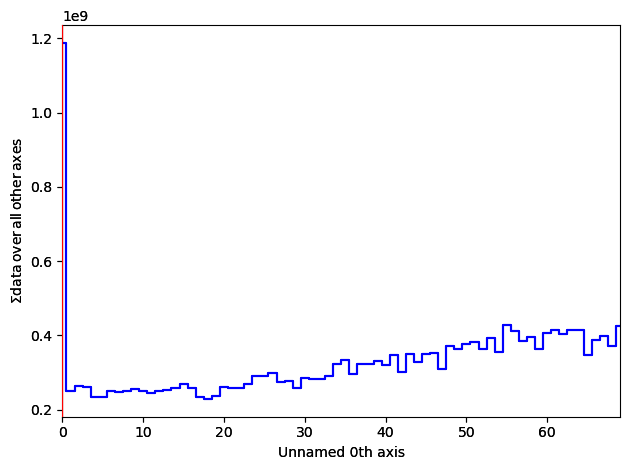

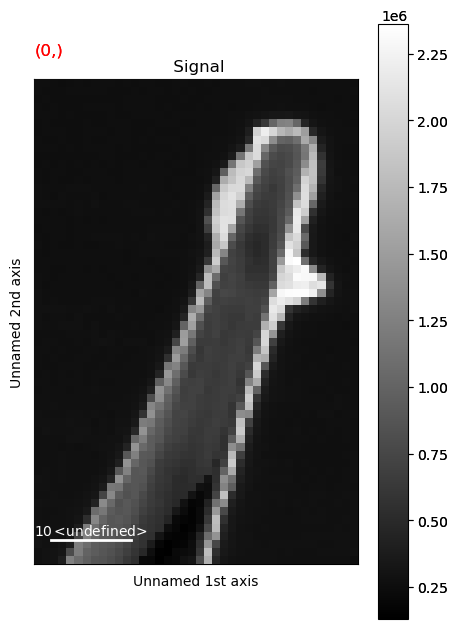

In [12]:
target1 = hs.signals.Signal2D(s_PL_stack)
target1.plot()

In [13]:
#load the reconstruction
inpath = "D:/data/August2022/TiNi/tomo/"

rec = hs.load(inpath + 'sirt10cut.tif')
rec.set_signal_type('electron_diffraction')

40404

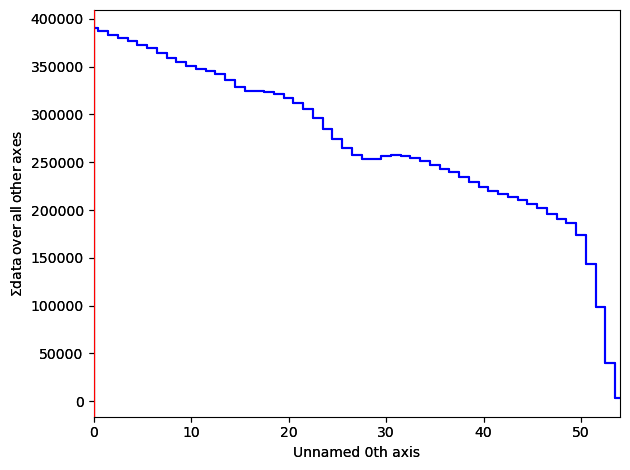

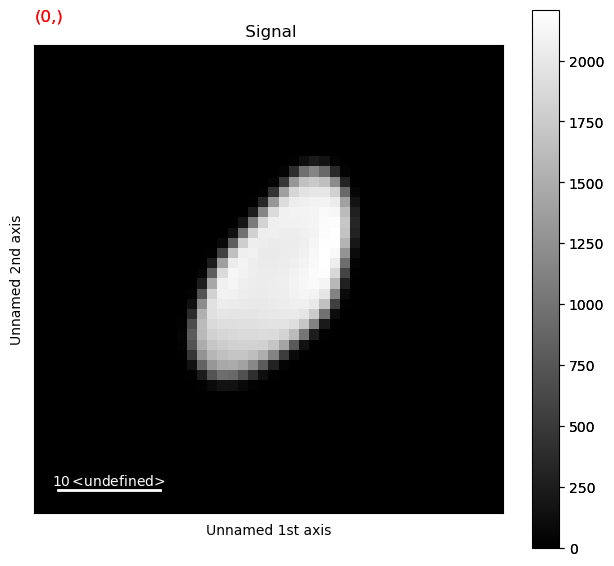

In [14]:
meanscale = 0.7163452999020451
recb = resize(rec.data, ( np.round(meanscale*(rec.data.shape[0] / 4)), np.round(meanscale*(rec.data.shape[1] / 4)), np.round(meanscale*(rec.data.shape[2] / 4))), anti_aliasing=True)
recb = hs.signals.Signal2D(recb)
recb.set_signal_type('electron_diffraction')
recb.plot(cmap='gray')

del rec
gc.collect()

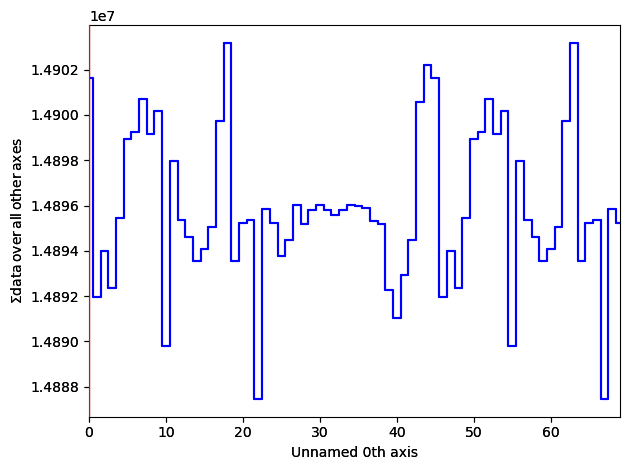

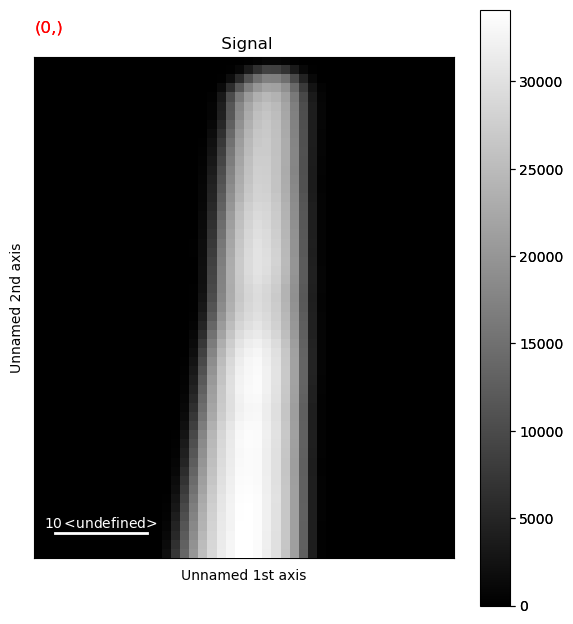

In [ ]:
from skimage.transform import radon

# Get the reprojected tilt series from the reconstruction
#change ti
starttilt = -64
endtilt = 70
tiltstep = 2
proj= np.zeros((Ntilts,recb.data.shape[0], recb.data.shape[2]))

for ll in range(Ntilts):
    for l in range(recb.data.shape[0]):
        theta = np.linspace(starttilt + ll*tiltstep,1,1) 
        R=radon(recb.data[l,:,:],theta, circle=True)
        proj[ll,recb.data.shape[0]-l-1,:] = np.squeeze(R)

proj1 = hs.signals.Signal2D(proj)
proj1.set_signal_type('electron_diffraction')
proj1.plot(cmap='gray',norm='auto' )

Text(0.5, 1.0, '3')

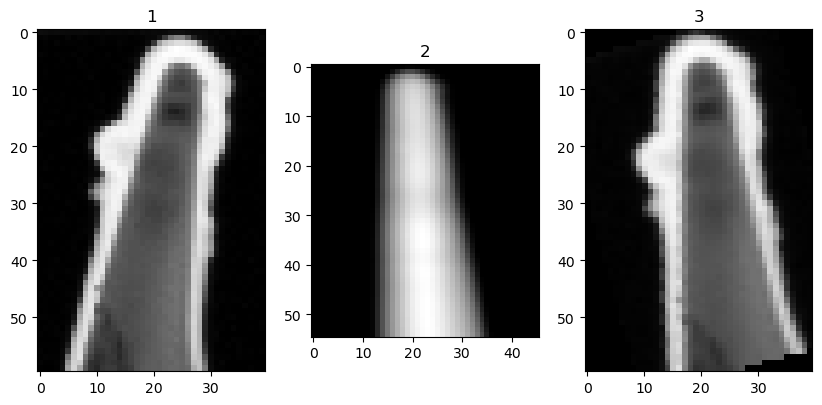

In [19]:
#register the SI images to the reconstruction similarly as the 4dstem images

from matplotlib.colors import LogNorm
from pylab import figure, cm

#change output path here
outpathSI = 'D:/data/August2022/TiNi/tomo/Tomo_44/post/'
os.makedirs(outpathSI, exist_ok=True)

# I used a mask to cut the lower part of the images away. this made the registration easier...
# if no mask, use s_ll.data.shape[0]
Cutmask = 35
#Cutmask = s_ll.data.shape[0] -1

path = outpathSI + 'transforms/' 

R = sitk.ImageRegistrationMethod()

#use the same scaling as before
S2DT = sitk.Euler2DTransform()

#R.SetMetricAsMeanSquares()
#R.SetMetricAsJointHistogramMutualInformation()
R.SetMetricAsCorrelation()
#R.SetMetricAsMattesMutualInformation(100)
#R.SetMetricSamplingPercentage(0.5)
#R.SetMetricSamplingStrategy(R.RANDOM)

R.SetOptimizerAsRegularStepGradientDescent(1.0, 0.001, 200)
R.SetOptimizerScalesFromIndexShift()
R.SetInterpolator(sitk.sitkLinear)


s_ZL_stack_aligned = np.zeros((Ntilts, s_ll.data.shape[0], s_ll.data.shape[1]), dtype=s_ll.data.dtype)
s_PL_stack_aligned = np.zeros((Ntilts, s_ll.data.shape[0], s_ll.data.shape[1]), dtype=s_ll.data.dtype)

maskdp = np.ones((s_ll.data.shape[0],s_ll.data.shape[1]),dtype=np.ubyte) # mask the bottom part of the images to ease the registration process
maskdp[Cutmask:,:] = 0
maskproj = np.ones((proj1.data.shape[0],proj1.data.shape[1]),dtype=np.ubyte)
maskproj[Cutmask:,:] = 0

R.SetMetricMovingMask(sitk.GetImageFromArray(maskdp))
R.SetMetricFixedMask(sitk.GetImageFromArray(maskproj))

for l in range(Ntilts): #Ntilts
    
  #  print('l', l)
    
    tilt0 = proj1.data[l,:,:]      
    vdf = s_ZL_stack[l,:,:]*-1
    vdf1 = s_PL_stack[l,:,:]
    
    tilt0 = tilt0 - tilt0.min()
    tilt0 = tilt0/tilt0.max()

    vdf   = vdf - vdf.min()
    vdf   = vdf/vdf.max()
    
    vdf1   = vdf1 - vdf1.min()
    vdf1   = vdf1/vdf1.max()
    
    fixed1 = sitk.GetImageFromArray(tilt0)
    moving1= sitk.GetImageFromArray(vdf)
    moving3= sitk.GetImageFromArray(vdf1)

    fixed = sitk.Cast(sitk.RescaleIntensity(fixed1), sitk.sitkFloat32)
    moving = sitk.Cast(sitk.RescaleIntensity(moving1), sitk.sitkFloat32)
    moving2 = sitk.Cast(sitk.RescaleIntensity(moving3), sitk.sitkFloat32)

    tx = sitk.CenteredTransformInitializer(fixed, moving, S2DT)
    R.SetInitialTransform(tx)

    outTx = R.Execute(fixed, moving)
    
    test1 = 'transforms_' + str(l)
    sitk.WriteTransform(outTx, path + test1 + '.tfm') #handling the transforms later on proved to be difficult. Its easier to save them and reload.
   
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0.)
    resampler.SetTransform(outTx)

    outr1 = resampler.Execute(moving)
    out1 = sitk.GetArrayFromImage(outr1)
    
    outr2 = resampler.Execute(moving2)
    out2 = sitk.GetArrayFromImage(outr2)
    
    s_ZL_stack_aligned[l,:,:] = out1
    s_PL_stack_aligned[l,:,:] = out2

    

name = 'EELS_SI_ZL_aligned_tiltseries'  + '.mrc'

dp3d  = mrcfile.new(outpathSI + name, s_ZL_stack_aligned.astype(np.float32),overwrite=True)
dp3d.close()

name = 'EELS_SI_PL_aligned_tiltseries'  + '.mrc'

dp3d  = mrcfile.new(outpathSI + name, s_PL_stack_aligned.astype(np.float32),overwrite=True)
dp3d.close()

target1 = hs.signals.Signal2D(s_ZL_stack_aligned)
target2 = hs.signals.Signal2D(s_PL_stack_aligned)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(vdf1,cmap='gray',vmin=0.01, vmax=1)
plt.title("1")
fig.add_subplot(1, 3, 2)
plt.imshow(tilt0,cmap='gray',vmin=0.01, vmax=1)
plt.title("2")
fig.add_subplot(1, 3, 3)
plt.imshow(out2,cmap='gray') 
plt.title("3")


#meanscale2 0.7163452999020451

Use the 
EELS_SI_ZL_aligned_tiltseries.mrc and 
EELS_SI_PL_aligned_tiltseries.mrc
as a normal tiltseries e.g. in tomviz software to calculate the reconstructions.
I opened them in DM, then saved them as .tif files so tomviz understands them...